### TODO

- Find the right way to turn the solution into integers

In [37]:
from random import randint
import sys

import numpy as np
import scipy.optimize as optimize
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%xmode plain

def init_simulation(num_nodes, 
                    num_days, 
                    icu_capacities = None, 
                    transport_capacities = None, 
                    ini_path = None, 
                    demand_min = 80, 
                    demand_max = 90):
    if ini_path:
        print("you can also upload an .ini file")
        raise NotImplemented
    else:
        demand = []
        for node in range(num_nodes):
            demand.append(list(np.random.randint(demand_min, demand_max, size = num_days)))

    return icu_capacities, transport_capacities, demand


def calculate_outgoing(array,day,node):
    return sum(array[day][node])


def calculate_incoming(array,day,node):
    total_outgoing = 0
    for n in range(num_nodes):
        total_outgoing = total_outgoing + array[day][n][node]
    return total_outgoing


def demand_day_node_raw(node_capacity, demand_day, left_day, received_day, demand_previous_days, left_previous_days, received_previous_days):
    return demand_day - left_day + received_day+ min(demand_previous_days-left_previous_days+received_previous_days, node_capacity)


def demand_day_node(movements,day,node):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    total_received_patients = 0
    total_outbound_patients = 0
    accumulated_demand = 0
    for d in range(day+1):
        total_received_patients = total_received_patients + calculate_incoming(movements_res,d,node)
        total_outbound_patients = total_outbound_patients + calculate_outgoing(movements_res,d,node)
    accumulated_demand = sum(demands[node][:day])
    
    demand = max(0, demand_day_node_raw(node_capacities[node],demands[node][day], 
                                        calculate_outgoing(movements_res,day,node), calculate_incoming(movements_res,day,node),
                                        accumulated_demand, total_outbound_patients, total_received_patients                
                ))
    return demand


def calc_total_unnatended(movements):
    total = 0
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    for node in range(num_nodes):
        for day in range(num_days):
            unnatended_not_attended = max(0, demand_day_node(movements,day,node) - node_capacities[node])
            unnant_because_transp = penalization_transport*movements_res[day].sum()
            total = total + unnatended_not_attended + unnant_because_transp
    return total


def outgoing_list(movements):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    outgoing_list = list()
    for day in range(num_days):
        for node in range(num_nodes):
            outgoing_list.append(calculate_outgoing(movements_res,day,node))
    return outgoing_list

def generate_bounds():
    outgoing_list = list()
    for day in range(num_days):
        for outgoing_node in range(num_nodes):
            for incoming_node in range(num_nodes):
                outgoing_list.append((0,transport_capacities[outgoing_node]))
    return outgoing_list

def f_cons(node_id, day):
    return lambda x: transport_capacities[node_id] - calculate_outgoing(np.reshape(x,(num_days,num_nodes,num_nodes)),day ,node_id)


def split_n(num, num_nodes):
    #TODO this function is not truly random
    pieces = []
    for idx in range(num_nodes-1):
        pieces.append(randint(1,num-sum(pieces)-num_nodes+idx))

    pieces.append(num-sum(pieces))
    return pieces

def return_solution_info(movements,icu_capacities,demands):
    occupancy = []
    unattended = []
    for node in range(num_nodes):
        occupancy_list_temp = []
        unattended_list_temp = []
        for day in range(num_days):
            occupancy_temp = demand_day_node(movements,day,node)
            unattended_temp = max(0, occupancy_temp - icu_capacities[node])
            occupancy_list_temp.append(occupancy_temp)
            unattended_list_temp.append(unattended_temp)
        occupancy.append(occupancy_list_temp)
        unattended.append(unattended_list_temp)
    return occupancy, unattended

Exception reporting mode: Plain


In [ ]:
51.543321, -0.178196, 51,49, -0.079

In [53]:
london_region_hospitals = (pd.read_csv("../hospitalData_beds.csv")
                           .query("51.19 < Latitude < 51.543321 & -0.18 < Longitude < -0.07")
                            [["OrgName", "Latitude", "Longitude", "Genera_Acute_beds_open_night", "Total_ICU_beds"]]
                          )
london_region_hospitals

,OrgName,Latitude,Longitude,Genera_Acute_beds_open_night,Total_ICU_beds
9,GUY'S AND ST THOMAS' NHS FOUNDATION TRUST,51.497959,-0.118891,1047,46
11,CROYDON HEALTH SERVICES NHS TRUST,51.389130,-0.108769,454,20
17,MOORFIELDS EYE HOSPITAL NHS FOUNDATION TRUST,51.527245,-0.089874,6,0
21,UNIVERSITY COLLEGE LONDON HOSPITALS NHS FOUNDA...,51.524891,-0.136896,807,35
22,ROYAL BROMPTON & HAREFIELD NHS FOUNDATION TRUST,51.489742,-0.170841,400,18
24,EPSOM AND ST HELIER UNIVERSITY HOSPITALS NHS T...,51.397251,-0.163248,754,33
26,IMPERIAL COLLEGE HEALTHCARE NHS TRUST,51.520702,-0.163316,1063,46
60,SURREY AND SUSSEX HEALTHCARE NHS TRUST,51.219192,-0.161995,700,31


In [55]:
london_region_hospitals["transport_capacity"] = 30
penalization_transport = 0
num_days = 4
num_nodes = london_region_hospitals.shape[0]

node_capacities, transport_capacities, demands = init_simulation(num_nodes, 
                                                                 num_days, 
                                                                 icu_capacities=london_region_hospitals["Total_ICU_beds"].values,
                                                                 transport_capacities=london_region_hospitals["transport_capacity"].values, 
                                                                 demand_min = 5, demand_max = 70)
print(f"""Randomly generated
{num_days} days, {num_nodes} hospitals
ICU capacities of hospitals: {node_capacities}
Daily transport capacities: {transport_capacities}, 
Daily simulated demand (from uniform distrution): 
{demands}""")

Randomly generated
4 days, 8 hospitals
ICU capacities of hospitals: [46 20  0 35 18 33 46 31]
Daily transport capacities: [30 30 30 30 30 30 30 30], 
Daily simulated demand (from uniform distrution): 
[[45, 65, 64, 67], [26, 33, 7, 46], [16, 66, 62, 36], [65, 29, 12, 19], [9, 29, 5, 44], [45, 45, 12, 12], [42, 65, 18, 58], [17, 60, 50, 32]]


In [56]:
#define constraints
cons = []
for node in range(num_nodes):
    for day in range(num_days):
        cons.append({'type': 'ineq', 'fun': f_cons(node,day)})

        
#no movement matrix, the base for generating random ones and one of the ones to test as init matrix 
no_movement = np.array([[[0]*num_nodes]*num_nodes]*num_days)

In [57]:
def random_init(knockdown_days = False, movement_intensity = 1, random_intensity = False, prior_matrix = np.array([])): 
    random_movement = prior_matrix.copy() if prior_matrix.any() else no_movement.copy()
    #if knockdown days is active, behave like a dropdown NN layer and drop half of the days movements
    active_days = np.random.choice([1,0], size=num_days) if knockdown_days else [1]*num_days
    for day in range(num_days):
        if active_days[day]:
            for node_x in range(num_nodes):
                movement_intensity = np.random.uniform() if random_intensity else movement_intensity
                #splits a number in a list of numbers pseudo randomly
                split_nodes = split_n(max(num_nodes+1, 
                                          np.ceil(transport_capacities[node_x]*movement_intensity)), 
                                      num_nodes)
                for node_y in range(num_nodes):
                    if node_x != node_y: 
                        if np.random.choice([0,1]): #allow numbers to decrease too
                            random_movement[day, node_x, node_y] += split_nodes[node_y]
                        else: 
                            random_movement[day, node_x, node_y] -= split_nodes[node_y]
                            random_movement[day, node_x, node_y] = max(0, random_movement[day, node_x, node_y])
                    
    return random_movement

### The main loop that generates random init matrices

In [ ]:
%%time

#parameters to minimize
min_unnatended = sys.maxsize
best_result = None
result_matrix = None
#iterate through low to high intensity movement simulation
steps = []
knockdown = True
win_init_matrix = no_movement.copy()
iterations = 100
movement_intensity = 0.5
miss = 0
candidates = []
bounds_movement = generate_bounds()
for i in range(iterations):
    print(f"i:{i} intensity: {movement_intensity:.2f} knockdown: {knockdown} ", end="")

    if movement_intensity < 0.1 or miss >= 25:
        miss = 0
        #if there are candidates, try those first with reasonable parameters
        if candidates:
            print(f"using candidate from {len(candidates)} candidates list")
            movement = candidates.pop() 
            movement_intensity = 0.5
            knockdown = True
            miss = 0
        else:
            #otherwise go all-in
            print("going into full evolution", end="")
            movement = random_init(False, 1, prior_matrix=win_init_matrix)
    else:
        movement = random_init(knockdown, movement_intensity, prior_matrix=win_init_matrix)
        
        result = optimize.minimize(calc_total_unnatended, 
                                   movement, 
                                   method='SLSQP', 
                                   constraints=cons, 
                                   bounds=bounds_movement)

        current_unnatended = calc_total_unnatended(np.rint(result.x))
        print(f"Result:{current_unnatended:.0f}", end="")
        steps.append([movement_intensity, knockdown, current_unnatended])
        if min_unnatended == current_unnatended:
            print(" <--saving!", end="")        
            candidates.append(movement)
        elif min_unnatended > current_unnatended:
            knockdown = True
            miss = 0
            movement_intensity *= 0.9
            movement_intensity = min(0.5, movement_intensity)
            candidates = []
            print(" <--best!", end="")
            min_unnatended = int(current_unnatended)
            best_result = result
            result_matrix = np.reshape(np.rint(result.x),(num_days,num_nodes,num_nodes))
            win_init_matrix = movement
        else:
            movement_intensity = min(1, movement_intensity*1.05)
            miss += 1

    print("")
        
print("\nDone")

i:0 intensity: 0.50 knockdown: True Result:872 <--best!
i:1 intensity: 0.45 knockdown: True Result:862 <--best!
i:2 intensity: 0.41 knockdown: True Result:857 <--best!
i:3 intensity: 0.36 knockdown: True Result:861
i:4 intensity: 0.38 knockdown: True Result:858
i:5 intensity: 0.40 knockdown: True Result:861
i:6 intensity: 0.42 knockdown: True 

### These are the unnatended that we get with inaction

In [31]:
calc_total_unnatended(no_movement)

619

### This is the best result found

In [32]:
min_unnatended

470

### This the movement matrix

In [33]:
result_matrix

array([[[ 0., 39.,  6., 15., 17.],
        [32.,  0.,  3.,  4.,  2.],
        [ 1., 16.,  0., 14., 21.],
        [ 3.,  2.,  1.,  0.,  1.],
        [19.,  6., 14.,  7.,  0.]],

       [[ 0.,  1.,  1.,  2.,  3.],
        [28.,  0., 13.,  6., 25.],
        [41., 13.,  0.,  5.,  7.],
        [29., 27.,  8.,  0.,  9.],
        [30.,  1., 15.,  8.,  0.]],

       [[ 0.,  2.,  1.,  2.,  4.],
        [41.,  0.,  2.,  5., 11.],
        [51.,  7.,  0., 12.,  8.],
        [53.,  5.,  2.,  0.,  7.],
        [25., 27.,  5.,  2.,  0.]]])

### These are the stats day by day

In [34]:
occupancy, unattended = return_solution_info(result_matrix,node_capacities,demands)

In [35]:
occupancy

[[72.0, 241.0, 315.0],
 [50.0, 49.0, 51.0],
 [40.0, 42.0, 42.0],
 [57.0, 8.0, 7.0],
 [21.0, 20.0, 22.0]]

In [11]:
unattended

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1.0], [0, 0, 0, 0, 0]]

In [12]:
df = pd.DataFrame(steps)
df.columns = ["movement_intensity", "knockdown", "result"]

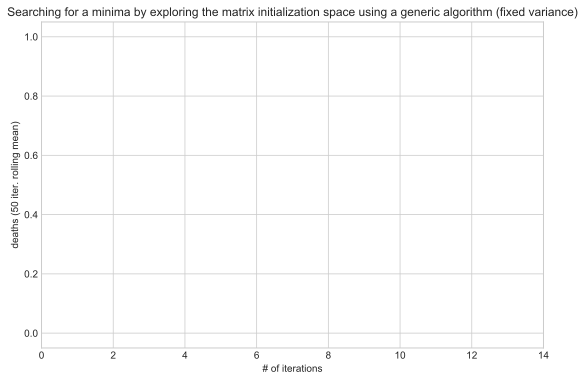

In [13]:
df.result.rolling(50).mean().plot(figsize=(9, 6), title="Searching for a minima by exploring the matrix initialization space using a generic algorithm (fixed variance)")
plt.xlabel("# of iterations")
plt.ylabel("unnatended (50 iter. rolling mean)");

In [14]:
for node in range(num_nodes):
    for day in range(num_days):
        print(f'Node: {node}, Day: {day}, Demand: {demand_day_node(np.rint(result.x),day,node)}')

Node: 0, Day: 0, Demand: 383.0
Node: 0, Day: 1, Demand: 577.0
Node: 0, Day: 2, Demand: 909.0
Node: 0, Day: 3, Demand: 1205.0
Node: 0, Day: 4, Demand: 1593.0
Node: 1, Day: 0, Demand: 0
Node: 1, Day: 1, Demand: 0
Node: 1, Day: 2, Demand: 0
Node: 1, Day: 3, Demand: 0
Node: 1, Day: 4, Demand: 9.0
Node: 2, Day: 0, Demand: 0
Node: 2, Day: 1, Demand: 0
Node: 2, Day: 2, Demand: 72.0
Node: 2, Day: 3, Demand: 69.0
Node: 2, Day: 4, Demand: 104.0
Node: 3, Day: 0, Demand: 323.0
Node: 3, Day: 1, Demand: 603.0
Node: 3, Day: 2, Demand: 747.0
Node: 3, Day: 3, Demand: 874.0
Node: 3, Day: 4, Demand: 978.0
